# Delay Prediction in Dutch Train Services

### Objective

The objective of this project is to predict train delays in the Netherlands using passenger train service data from 2024. (Dataset link: https://www.rijdendetreinen.nl/en/open-data/train-archive)

Each row in the dataset represents a stop of a train service at a station.  
A service contains multiple stops, starting with an initial departure and ending with a final arrival.


### Exploratory Data Analysis: Data cleaning

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.gridspec import GridSpec

#### Loading the dataset

In [2]:
data = pd.read_csv('services-2024.csv')
data.head()

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station code,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change,Stop:Planned platform,Stop:Actual platform
0,12690865,2024-01-01,Intercity,NS,1410,False,False,2,114307592,RTD,Rotterdam Centraal,NaN,NaN,NaN,2024-01-01T02:00:00+01:00,0.0,False,False,9,9
1,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307593,DT,Delft,2024-01-01T02:13:00+01:00,0.0,False,2024-01-01T02:13:00+01:00,0.0,False,False,1,1
2,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307594,GV,Den Haag HS,2024-01-01T02:21:00+01:00,0.0,False,2024-01-01T02:22:00+01:00,0.0,False,False,6,6
3,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307595,LEDN,Leiden Centraal,2024-01-01T02:35:00+01:00,0.0,False,2024-01-01T02:40:00+01:00,0.0,False,True,5b,8b
4,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307596,SHL,Schiphol Airport,2024-01-01T03:00:00+01:00,0.0,False,2024-01-01T03:03:00+01:00,0.0,False,False,3,3


Columns description:
1. Service:RDT-ID :Unique identifier (service), This is the ID that Rijden de Treinen uses for this service. It has no useful meaning beyond uniquely identifying a single service on a single date. 
2. Service:Date :Service date (schedule date) , The scheduled service date for this service. (PS: The service date is not always the same as the actual date. For example, a service that departs at 23:59 on 31 July and arrives at 02:00 on 1 August has a service date of 31 July. Delays do not affect the service date.) 
3. Service:Type :Service type, The service type, for example: Intercity, Sprinter or ICE International. 
4. Service:Company :Operator, Company operating this service, like NS or Arriva. 
5. Service:Train number :Train number ,The train number (service number) for this service uniquely identifies this service on this date. This number is sometimes also communicated to passengers (especially for international trains). (PS: A single service may sometimes have multiple train numbers. For example, when a train is split in two parts, or when a train changes a train number on a major station halfway.) 
6. Service:Completely cancelled :Service is fully cancelled , This column is true when all stops of this service have been cancelled. Or in other words: when the train does not run at all. 
7. Service:Partly cancelled :Partially cancelled , This column is true when one or more stops of this service have been cancelled. Or in other words: when the train does not run on a part of the route. 
8. Service:Maximum delay :Highest delay for this service , The highest delay (in minutes) of all stops of this service. 
9. Stop:RDT-ID :Unique identifier (stop), Unique identifier for this stop. This ID is unique for each stop in the dataset. It has no further useful meaning. 
10. Stop:Station code :Station code, Code (abbreviation) of the station name
11. Stop:Station name :Station name , The name of the station. 
12. Stop:Arrival time :Arrival time , Scheduled arrival time in RFC 3339 format. This column is empty when no arrival was scheduled. (PS: so it is obvious that for the departure of each service this colomn is empty, since it is the start point so there is no arrival only departure) 
13. Stop:Arrival delay :Arrival delay : Arrival delay in minutes. This column is empty when no arrival was scheduled. (PS: same it is empty in the first departure of each service) 
14. Stop:Arrival cancelled :Cancelled arrival, This column is true when the arrival at this stop has been cancelled. This column is empty when no arrival was scheduled.(PS: same it is empty in the first departure of each service) 
15. Stop:Departure time :Departure time , Scheduled departure time in RFC 3339 format. This column is empty when no departure was scheduled. (PS: it is empty for the final arrival of each service, there is no departure) 
16. Stop:Departure delay :Departure delay, Departure delay in minutes. This column is empty when no departure was scheduled.(PS: it is empty for the final arrival of each service, there is no departure) 
17. Stop:Departure cancelled :Cancelled departure ,This column is true when the departure at this stop has been cancelled. This column is empty when no departure was scheduled. (PS: it is empty for the final arrival of each service, there is no departure) 
18. Stop:Platform change :Platform change, This column is true when the platform of this stop has changed from the planned platform. 
19. Stop:Planned platform :Scheduled platform , The originally scheduled platform for this service. 
20. Stop:Actual platform :Actual platform, The platform that was actually used for this service.

#### Dataset dimensions

In [3]:
data.shape

(21857914, 20)

The dataset contains:

- 21.8 million rows
- 20 columns

This confirms that we are working with a large-scale real-world dataset, requiring careful memory management and efficient cleaning strategies.


#### Data structure

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21857914 entries, 0 to 21857913
Data columns (total 20 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Service:RDT-ID                int64  
 1   Service:Date                  object 
 2   Service:Type                  object 
 3   Service:Company               object 
 4   Service:Train number          int64  
 5   Service:Completely cancelled  bool   
 6   Service:Partly cancelled      bool   
 7   Service:Maximum delay         int64  
 8   Stop:RDT-ID                   int64  
 9   Stop:Station code             object 
 10  Stop:Station name             object 
 11  Stop:Arrival time             object 
 12  Stop:Arrival delay            float64
 13  Stop:Arrival cancelled        object 
 14  Stop:Departure time           object 
 15  Stop:Departure delay          float64
 16  Stop:Departure cancelled      object 
 17  Stop:Platform change          bool   
 18  Stop:Planned platfor

Important considerations:
- Time columns will later need conversion to datetime format.
- Cancellation columns should be carefully interpreted when cleaning missing values.

#### Data cleaning

Since the prediction task concerns delay estimation at stop level (arrival and departure delays), the dataset must first be carefully cleaned and structurally validated before proceeding to feature engineering and modeling.

In [5]:
data.isnull().sum()

Service:RDT-ID                        0
Service:Date                          0
Service:Type                          0
Service:Company                       0
Service:Train number                  0
Service:Completely cancelled          0
Service:Partly cancelled              0
Service:Maximum delay                 0
Stop:RDT-ID                           0
Stop:Station code                 27552
Stop:Station name                     0
Stop:Arrival time               2408990
Stop:Arrival delay              2408990
Stop:Arrival cancelled          2408990
Stop:Departure time             2411747
Stop:Departure delay            2411747
Stop:Departure cancelled        2411747
Stop:Platform change                  0
Stop:Planned platform           2884331
Stop:Actual platform            2884331
dtype: int64

Important interpretation:

Arrival and departure missing values are not necessarily data errors.  
By dataset definition:

- The first stop of a service has no arrival.
- The last stop of a service has no departure.

Therefore, some missing values are structurally expected.

In [6]:
data["Service:RDT-ID"].nunique()

2395636

The dataset contains 2,395,636 unique services

Since each service must have:
- One initial departure
- One final arrival

We expect approximately one structural arrival-null and one structural departure-null per service.

In [7]:
data=data.drop(columns=[
    "Stop:Station code",
    "Stop:Planned platform",
    "Stop:Actual platform"
])


In [8]:
data.shape

(21857914, 17)

In [9]:
data.head(30)

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change
0,12690865,2024-01-01,Intercity,NS,1410,False,False,2,114307592,Rotterdam Centraal,NaN,NaN,NaN,2024-01-01T02:00:00+01:00,0.0,False,False
1,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307593,Delft,2024-01-01T02:13:00+01:00,0.0,False,2024-01-01T02:13:00+01:00,0.0,False,False
2,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307594,Den Haag HS,2024-01-01T02:21:00+01:00,0.0,False,2024-01-01T02:22:00+01:00,0.0,False,False
3,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307595,Leiden Centraal,2024-01-01T02:35:00+01:00,0.0,False,2024-01-01T02:40:00+01:00,0.0,False,True
4,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307596,Schiphol Airport,2024-01-01T03:00:00+01:00,0.0,False,2024-01-01T03:03:00+01:00,0.0,False,False
5,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307597,Amsterdam Sloterdijk,2024-01-01T03:12:00+01:00,0.0,False,2024-01-01T03:12:00+01:00,0.0,False,False
6,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307598,Amsterdam Centraal,2024-01-01T03:18:00+01:00,1.0,False,2024-01-01T03:20:00+01:00,2.0,False,False
7,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307599,Amsterdam Bijlmer ArenA,2024-01-01T03:31:00+01:00,2.0,False,2024-01-01T03:31:00+01:00,2.0,False,False
8,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307600,Utrecht Centraal,2024-01-01T03:50:00+01:00,0.0,False,NaN,NaN,NaN,False
9,12690866,2024-01-01,Nightjet,NS Int,420,False,False,6,114307601,Nürnberg Hbf,NaN,NaN,NaN,2024-01-01T02:01:00+01:00,0.0,False,False


The columns Stop:Station code, Stop:Planned platform and Stop:Actual platform were removed.

Reasoning:
- Station name is already available (station code redundant).
- Platform information contains a large number of missing values.
- Platform assignment is not central to delay prediction in the first modeling iteration.

This reduces noise and simplifies the dataset.

In [10]:
grouped = data.groupby("Service:RDT-ID")

first_idx = grouped.head(1).index
last_idx = grouped.tail(1).index


In [11]:
middle_mask = ~data.index.isin(first_idx.union(last_idx))

In [12]:
middle_valid = (
    data["Stop:Arrival time"].notnull() &
    data["Stop:Departure time"].notnull() &
    data["Stop:Arrival delay"].notnull() &
    data["Stop:Departure delay"].notnull() &
    data["Stop:Arrival cancelled"].notnull() &
    data["Stop:Departure cancelled"].notnull()
)


In [13]:
df_clean = pd.concat([
    data.loc[first_idx],
    data.loc[last_idx],
    data[middle_mask & middle_valid]
]).sort_index()


In [14]:
df_clean.head(30)

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change
0,12690865,2024-01-01,Intercity,NS,1410,False,False,2,114307592,Rotterdam Centraal,NaN,NaN,NaN,2024-01-01T02:00:00+01:00,0.0,False,False
1,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307593,Delft,2024-01-01T02:13:00+01:00,0.0,False,2024-01-01T02:13:00+01:00,0.0,False,False
2,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307594,Den Haag HS,2024-01-01T02:21:00+01:00,0.0,False,2024-01-01T02:22:00+01:00,0.0,False,False
3,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307595,Leiden Centraal,2024-01-01T02:35:00+01:00,0.0,False,2024-01-01T02:40:00+01:00,0.0,False,True
4,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307596,Schiphol Airport,2024-01-01T03:00:00+01:00,0.0,False,2024-01-01T03:03:00+01:00,0.0,False,False
5,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307597,Amsterdam Sloterdijk,2024-01-01T03:12:00+01:00,0.0,False,2024-01-01T03:12:00+01:00,0.0,False,False
6,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307598,Amsterdam Centraal,2024-01-01T03:18:00+01:00,1.0,False,2024-01-01T03:20:00+01:00,2.0,False,False
7,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307599,Amsterdam Bijlmer ArenA,2024-01-01T03:31:00+01:00,2.0,False,2024-01-01T03:31:00+01:00,2.0,False,False
8,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307600,Utrecht Centraal,2024-01-01T03:50:00+01:00,0.0,False,NaN,NaN,NaN,False
9,12690866,2024-01-01,Nightjet,NS Int,420,False,False,6,114307601,Nürnberg Hbf,NaN,NaN,NaN,2024-01-01T02:01:00+01:00,0.0,False,False


This ensures:

- Structural first and last stops are preserved.
- Only middle stops with complete delay-related information are kept.
- Corrupted intermediate rows are removed.

In [15]:
print("Arrival nulls:",
      df_clean["Stop:Arrival time"].isnull().sum())

print("Departure nulls:",
      df_clean["Stop:Departure time"].isnull().sum())

print("Unique services:",
      df_clean["Service:RDT-ID"].nunique())


Arrival nulls: 2395215
Departure nulls: 2395127
Unique services: 2395636


Post-cleaning validation:

Arrival and departure null counts are slightly lower than the number of services.

Interpretation:
Some services begin with an arrival time or end with a departure time, since this does not affect delay prediction consistency, the dataset structure is considered valid.

#### Convert time columns to datetime

In [16]:
df_clean["Service:Date"] = pd.to_datetime(
    df_clean["Service:Date"],
    errors="coerce"
)

df_clean["Stop:Arrival time"] = pd.to_datetime(
    df_clean["Stop:Arrival time"],
    errors="coerce"
)

df_clean["Stop:Departure time"] = pd.to_datetime(
    df_clean["Stop:Departure time"],
    errors="coerce"
)

C:\Users\bouzi\AppData\Local\Temp\ipykernel_30856\1422333628.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_clean["Stop:Arrival time"] = pd.to_datetime(
C:\Users\bouzi\AppData\Local\Temp\ipykernel_30856\1422333628.py:11: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_clean["Stop:Departure time"] = pd.to_datetime(


#### Convert cancellation columns to boolean

In [17]:
df_clean["Stop:Arrival cancelled"] = df_clean["Stop:Arrival cancelled"].astype(bool)
df_clean["Stop:Departure cancelled"] = df_clean["Stop:Departure cancelled"].astype(bool)

#### Convert delay columns to numeric

In [18]:
df_clean["Stop:Arrival delay"] = pd.to_numeric(
    df_clean["Stop:Arrival delay"],
    errors="coerce"
)

df_clean["Stop:Departure delay"] = pd.to_numeric(
    df_clean["Stop:Departure delay"],
    errors="coerce"
)

#### Save the DataFrame as csv

In [19]:
df_clean.to_csv("df_clean.csv", index=False)
print(f"df_clean sauvegardé : {df_clean.shape[0]:,} lignes, {df_clean.shape[1]} colonnes")

df_clean sauvegardé : 21,838,516 lignes, 17 colonnes


### Exploratory Data Analysis: Data visualisation

In [40]:
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams.update({
    "figure.dpi": 130,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})
PALETTE = sns.color_palette("muted")

#### Preparing data subsets for visualization

In [20]:
df_service = (
    df_clean
    .groupby("Service:RDT-ID", as_index=False)
    .first()
)
df_service.head()

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change
0,12690865,2024-01-01,Intercity,NS,1410,False,False,2,114307592,Rotterdam Centraal,2024-01-01 02:13:00+01:00,0.0,True,2024-01-01 02:00:00+01:00,0.0,False,False
1,12690866,2024-01-01,Nightjet,NS Int,420,False,False,6,114307601,Nürnberg Hbf,2024-01-01 02:30:00+01:00,0.0,True,2024-01-01 02:01:00+01:00,0.0,False,False
2,12690867,2024-01-01,Intercity,NS,1409,False,False,10,114307610,Utrecht Centraal,2024-01-01 02:33:00+01:00,3.0,True,2024-01-01 02:16:00+01:00,0.0,False,False
3,12690868,2024-01-01,Intercity,NS,22205,False,False,5,114307619,Haarlem,2024-01-01 02:44:00+01:00,2.0,True,2024-01-01 02:34:00+01:00,2.0,False,True
4,12690869,2024-01-01,Stoptrein,Eurobahn,20394,True,True,0,114307623,Rheine,2024-01-01 03:03:00+01:00,0.0,True,2024-01-01 02:49:00+01:00,0.0,True,False


In [21]:
df_service["Service:Date"] = pd.to_datetime(df_service["Service:Date"])
df_service["month"]        = df_service["Service:Date"].dt.month
df_service["month_name"]   = df_service["Service:Date"].dt.strftime("%b")
df_service["weekday"]      = df_service["Service:Date"].dt.day_name()
df_service["week"]         = df_service["Service:Date"].dt.isocalendar().week.astype(int)

In [44]:
def delay_category(d):
    if d == 0:
        return "0 min (à l'heure)"
    elif d <= 3:
        return "1–3 min"
    elif d <= 5:
        return "4–5 min"
    elif d <= 15:
        return "6–15 min"
    else:
        return "> 15 min"

df_service["delay_cat"] = df_service["Service:Maximum delay"].apply(delay_category)
cat_order = ["0 min (à l'heure)", "1–3 min", "4–5 min", "6–15 min", "> 15 min"]

In [45]:
df_stops = df_clean.copy()
df_stops["dep_hour"] = (
    pd.to_datetime(df_stops["Stop:Departure time"], utc=True, errors="coerce")
    .dt.tz_convert("Europe/Amsterdam")
    .dt.hour
)
df_stops["arr_hour"] = (
    pd.to_datetime(df_stops["Stop:Arrival time"], utc=True, errors="coerce")
    .dt.tz_convert("Europe/Amsterdam")
    .dt.hour
)


In [46]:
df_mid = df_stops.dropna(subset=["Stop:Arrival delay", "Stop:Departure delay"])
df_mid.head()

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station name,...,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change,hour_departure,hour_arrival,day_of_week,month,dep_hour,arr_hour
1,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307593,Delft,...,2024-01-01 02:13:00+01:00,0.0,False,False,2,2,0,1,2.0,2.0
2,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307594,Den Haag HS,...,2024-01-01 02:22:00+01:00,0.0,False,False,2,2,0,1,2.0,2.0
3,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307595,Leiden Centraal,...,2024-01-01 02:40:00+01:00,0.0,False,True,2,2,0,1,2.0,2.0
4,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307596,Schiphol Airport,...,2024-01-01 03:03:00+01:00,0.0,False,False,3,3,0,1,3.0,3.0
5,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307597,Amsterdam Sloterdijk,...,2024-01-01 03:12:00+01:00,0.0,False,False,3,3,0,1,3.0,3.0


#### Distribution of maximum delay per service (KDE and ECDF)

C:\Users\bouzi\AppData\Local\Temp\ipykernel_15428\1338893173.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("viz_1_distribution_retard.png", bbox_inches="tight")
c:\Users\bouzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


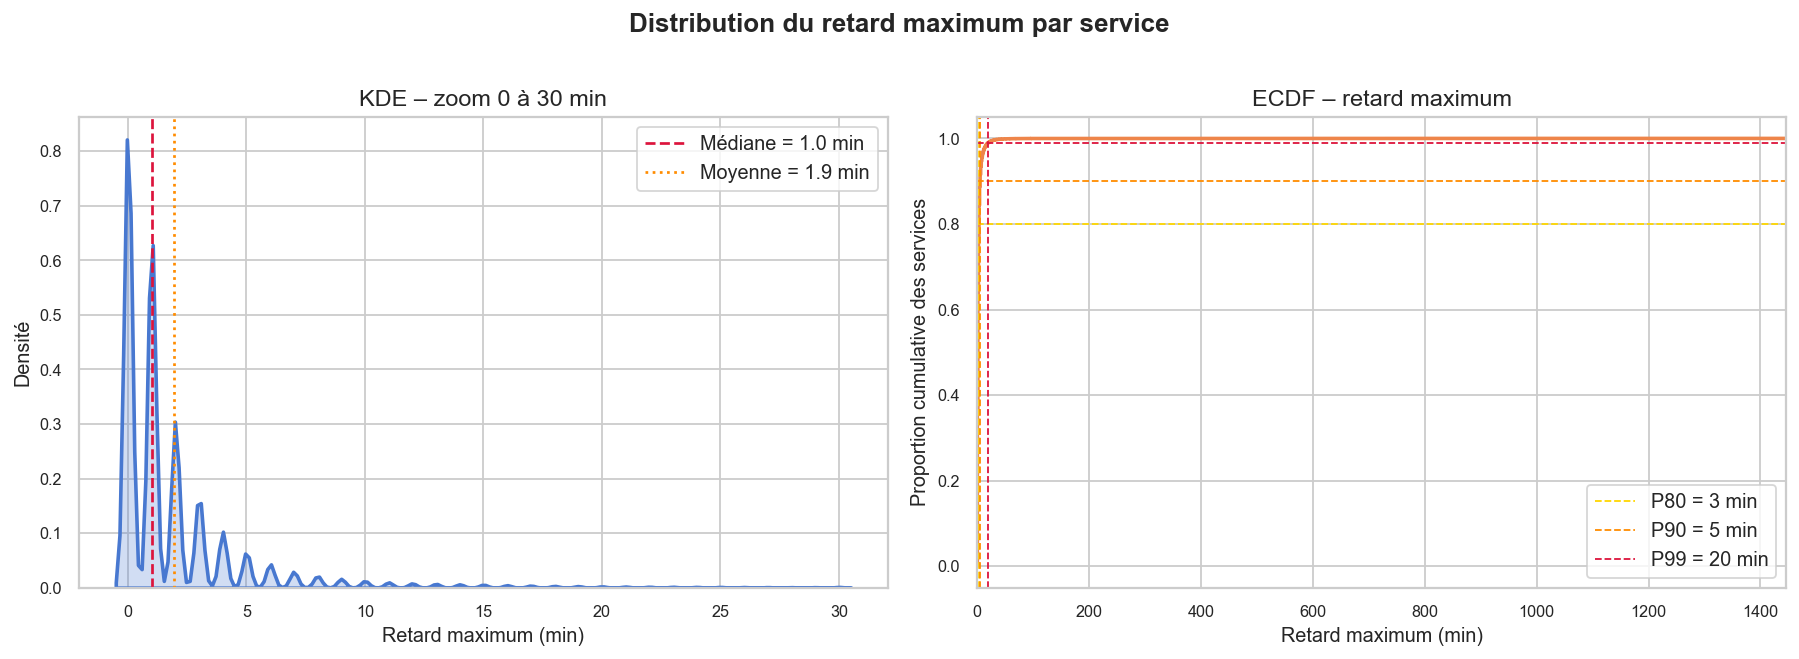

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Distribution du retard maximum par service", fontweight="bold", y=1.01)

# -- Panneau gauche : zoom 0–30 min, KDE
ax = axes[0]
data_kde = df_service.loc[
    df_service["Service:Maximum delay"].between(0, 30),
    "Service:Maximum delay"
]
sns.kdeplot(data_kde, ax=ax, fill=True, color=PALETTE[0], linewidth=2)
ax.axvline(data_kde.median(), color="crimson", linestyle="--", linewidth=1.5,
           label=f"Médiane = {data_kde.median():.1f} min")
ax.axvline(data_kde.mean(), color="darkorange", linestyle=":", linewidth=1.5,
           label=f"Moyenne = {data_kde.mean():.1f} min")
ax.set_xlabel("Retard maximum (min)")
ax.set_ylabel("Densité")
ax.set_title("KDE – zoom 0 à 30 min")
ax.legend()

# -- Panneau droit : ECDF pour voir les percentiles
ax2 = axes[1]
sorted_vals = np.sort(df_service["Service:Maximum delay"].values)
ecdf_y = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
ax2.plot(sorted_vals, ecdf_y, color=PALETTE[1], linewidth=2)
for pct, col in [(0.80, "gold"), (0.90, "darkorange"), (0.99, "crimson")]:
    val = np.percentile(sorted_vals, pct * 100)
    ax2.axhline(pct, color=col, linestyle="--", linewidth=1,
                label=f"P{int(pct*100)} = {val:.0f} min")
    ax2.axvline(val, color=col, linestyle="--", linewidth=1)
ax2.set_xlim(0, sorted_vals.max())
ax2.set_xlabel("Retard maximum (min)")
ax2.set_ylabel("Proportion cumulative des services")
ax2.set_title("ECDF – retard maximum")
ax2.legend()

plt.tight_layout()
plt.savefig("viz_1_distribution_retard.png", bbox_inches="tight")
plt.show()

The left panel (KDE) reveals a heavily right-skewed distribution: the vast majority of services experience little to no delay, with the highest density concentrated around 0–2 minutes. The median and mean are both very low, confirming that Dutch train services are generally punctual. However, the distribution has a long right tail, indicating the existence of outliers with significant delays.

The right panel (ECDF) quantifies this more precisely: approximately 80% of services have a maximum delay below a few minutes, while extreme delays (>15 min) represent only a small fraction of all services. This asymmetry is a crucial characteristic to keep in mind for modeling, as the target variable is highly imbalanced between "on-time" and "delayed" services.

#### Monthly evolution of the significant delay rate (> 5 min)

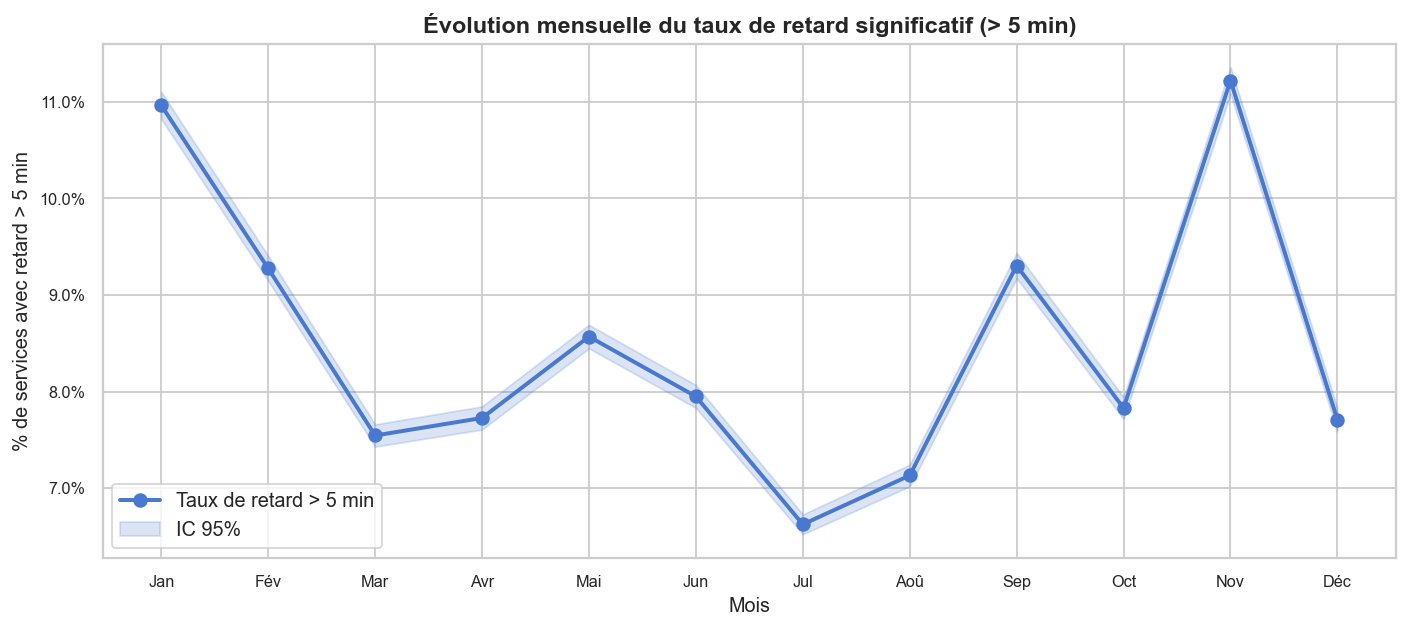

In [48]:
monthly = (
    df_service
    .groupby("month")
    .agg(
        total=("Service:Maximum delay", "count"),
        delayed=("Service:Maximum delay", lambda x: (x > 5).sum())
    )
    .reset_index()
)
monthly["rate"]    = monthly["delayed"] / monthly["total"]
monthly["ci"]      = 1.96 * np.sqrt(monthly["rate"] * (1 - monthly["rate"]) / monthly["total"])
month_labels       = ["Jan","Fév","Mar","Avr","Mai","Jun","Jul","Aoû","Sep","Oct","Nov","Déc"]
monthly["label"]   = monthly["month"].apply(lambda m: month_labels[m-1])

fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(monthly["month"], monthly["rate"] * 100, marker="o", linewidth=2.2,
        color=PALETTE[0], markersize=7, label="Taux de retard > 5 min")
ax.fill_between(
    monthly["month"],
    (monthly["rate"] - monthly["ci"]) * 100,
    (monthly["rate"] + monthly["ci"]) * 100,
    alpha=0.2, color=PALETTE[0], label="IC 95%"
)
ax.set_xticks(monthly["month"])
ax.set_xticklabels(monthly["label"])
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.set_xlabel("Mois")
ax.set_ylabel("% de services avec retard > 5 min")
ax.set_title("Évolution mensuelle du taux de retard significatif (> 5 min)", fontweight="bold")
ax.legend()
plt.tight_layout()
plt.savefig("viz_2_taux_retard_mensuel.png", bbox_inches="tight")
plt.show()


This line chart shows how the proportion of services with a maximum delay exceeding 5 minutes evolves across the 12 months of 2024. The 95% confidence interval confirms the reliability of each monthly estimate given the large sample size.
Certain months stand out with noticeably higher delay rates, which may be explained by seasonal factors such as adverse weather conditions (ice, wind) in winter months, or increased traffic volume during holiday periods. Conversely, summer months tend to show lower disruption rates. This monthly seasonality is an important signal that could be incorporated as a temporal feature in the prediction models

#### Average maximum delay by day of the week and service type

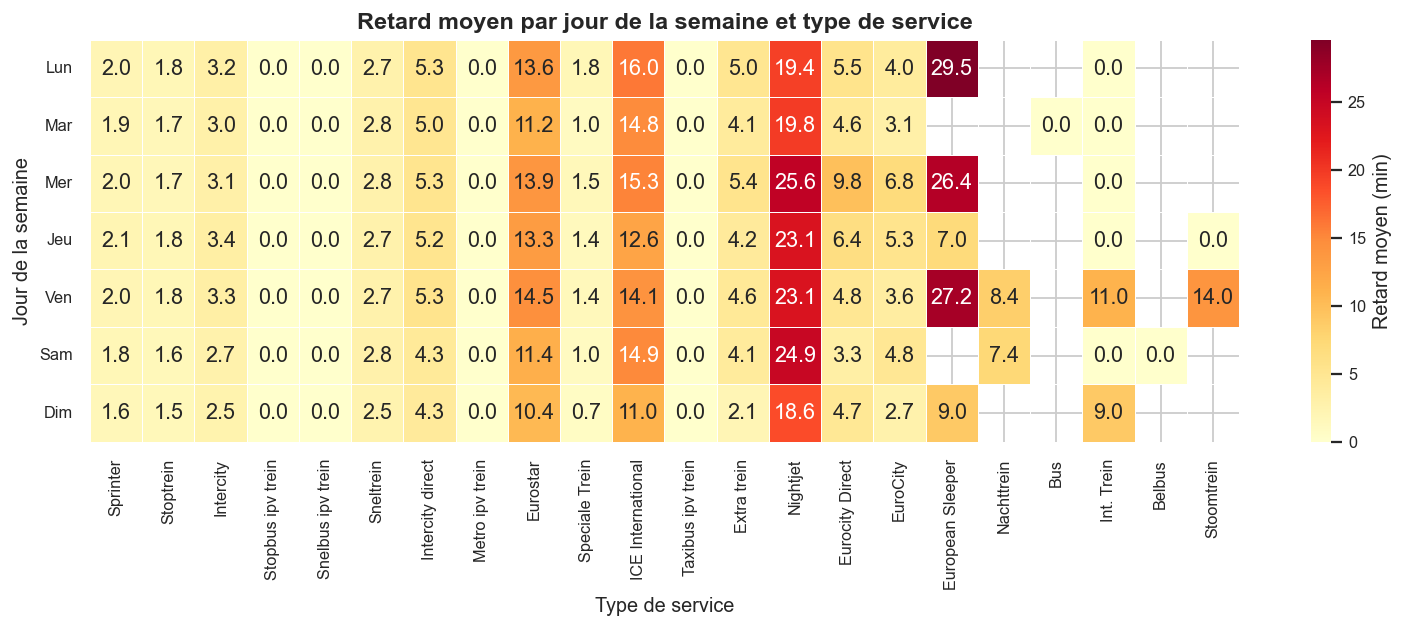

In [ ]:
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_fr    = ["Lun","Mar","Mer","Jeu","Ven","Sam","Dim"]

pivot = (
    df_service
    .groupby(["weekday", "Service:Type"])["Service:Maximum delay"]
    .mean()
    .unstack("Service:Type")
    .reindex(weekday_order)
)
type_counts = df_service["Service:Type"].value_counts()
top_types   = type_counts.index
pivot       = pivot[[c for c in top_types if c in pivot.columns]]

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(
    pivot, ax=ax, cmap="YlOrRd", annot=True, fmt=".1f",
    linewidths=0.5, linecolor="white",
    cbar_kws={"label": "Retard moyen (min)"}
)
ax.set_yticklabels(weekday_fr, rotation=0)
ax.set_xlabel("Type de service")
ax.set_ylabel("Jour de la semaine")
ax.set_title("Retard moyen par jour de la semaine et type de service", fontweight="bold")
plt.tight_layout()
plt.savefig("viz_3_heatmap_jour_type.png", bbox_inches="tight")
plt.show()

This heatmap cross-references two categorical dimensions, the day of the week and the service type, to identify delay patterns. The color intensity (yellow to red) reflects the average maximum delay in minutes.

A key observation is that international and long-distance service types (Nightjet, European Sleeper, ICE international) tend to accumulate higher delays, likely because any disruption on one segment propagates across the full route. In contrast, regional trains (Sprinter, Stoptrein) show more stable, lower delays.

From a temporal perspective, certain days, often mondays and fridays, may show slightly elevated delays compared to mid-week, reflecting commuting pressure. Weekends generally show lower delays due to reduced traffic volume. These interaction effects between day and service type are valuable features for delay prediction.

#### Weekly evolution of average maximum delay by operator (4-week rolling mean)

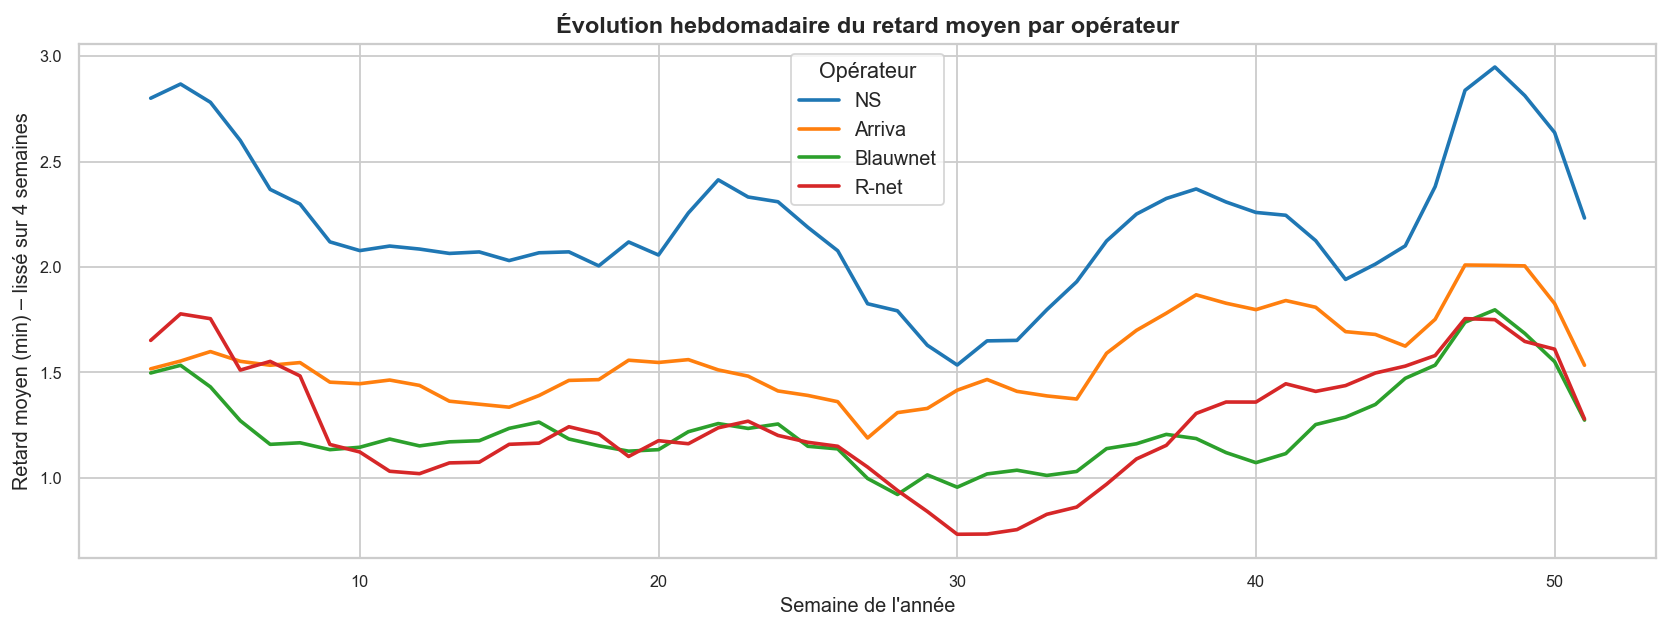

In [50]:
top_companies = df_service["Service:Company"].value_counts().head(4).index

fig, ax = plt.subplots(figsize=(13, 5))
colors_company = sns.color_palette("tab10", n_colors=4)

for i, company in enumerate(top_companies):
    sub = (
        df_service[df_service["Service:Company"] == company]
        .groupby("week")["Service:Maximum delay"]
        .mean()
        .rolling(4, center=True)
        .mean()
    )
    ax.plot(sub.index, sub.values, linewidth=2, label=company, color=colors_company[i])

ax.set_xlabel("Semaine de l'année")
ax.set_ylabel("Retard moyen (min) – lissé sur 4 semaines")
ax.set_title("Évolution hebdomadaire du retard moyen par opérateur", fontweight="bold")
ax.legend(title="Opérateur")
plt.tight_layout()
plt.savefig("viz_4_retard_semaine_operateur.png", bbox_inches="tight")
plt.show()

This line chart (4-week rolling average) captures the long-term trends in delay per operating company throughout 2024.

NS, as the dominant operator, provides the most readable trend. Other operators show more variability, partly due to their smaller service volumes. Peaks visible in specific weeks likely correspond to external events such as strikes, severe weather, or infrastructure incidents. The relative positioning of operators reveals that some consistently perform worse than others.

#### Distribution of stop-level Arrival delay by service type

C:\Users\bouzi\AppData\Local\Temp\ipykernel_15428\4047981138.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


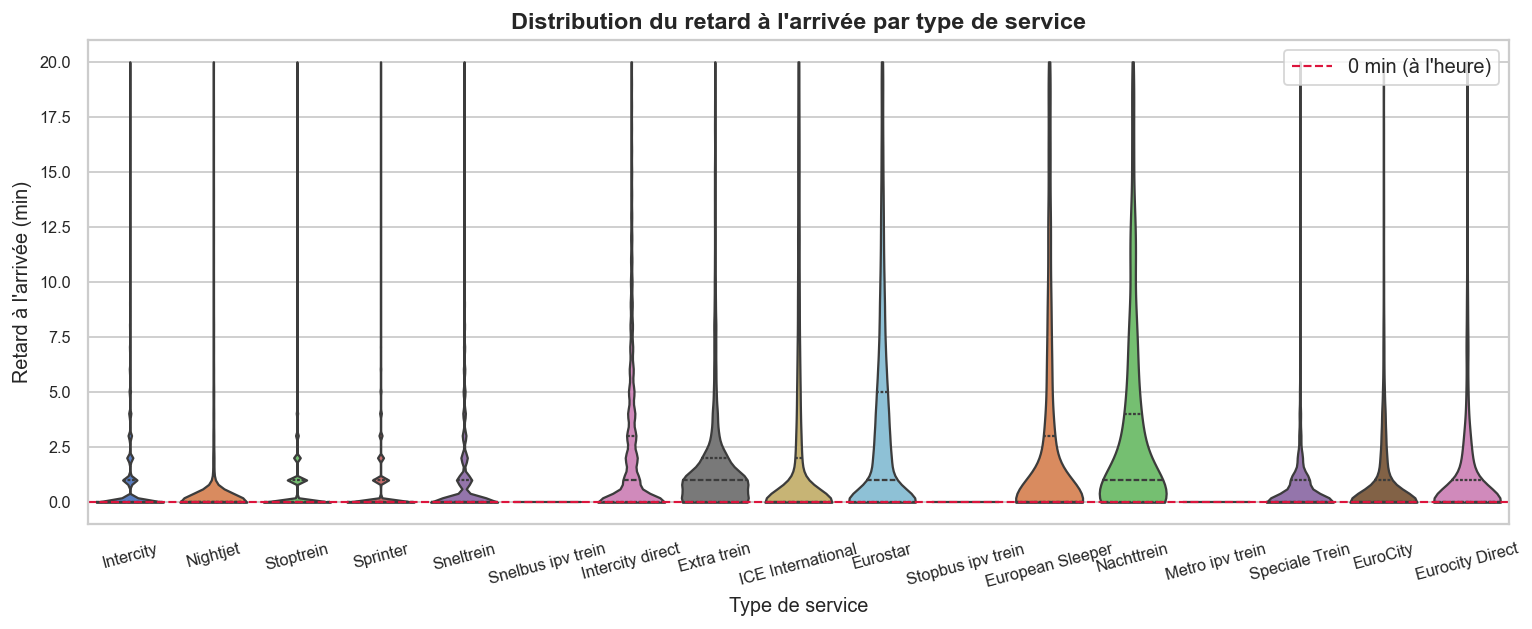

In [51]:
fig, ax = plt.subplots(figsize=(12, 5))

# On travaille sur les stops intermédiaires (arrival_delay)
df_mid_sample = df_mid.dropna(subset=["Stop:Arrival delay"])
types_ok      = df_mid_sample["Service:Type"].value_counts()
types_ok      = types_ok[types_ok > 500].index
df_violin     = df_mid_sample[
    df_mid_sample["Service:Type"].isin(types_ok) &
    df_mid_sample["Stop:Arrival delay"].between(-2, 20)
]

sns.violinplot(
    data=df_violin, x="Service:Type", y="Stop:Arrival delay",
    palette="muted", inner="quartile", cut=0, ax=ax
)
ax.axhline(0, color="crimson", linestyle="--", linewidth=1.2, label="0 min (à l'heure)")
ax.set_xlabel("Type de service")
ax.set_ylabel("Retard à l'arrivée (min)")
ax.set_title("Distribution du retard à l'arrivée par type de service", fontweight="bold")
ax.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("viz_5_violin_type.png", bbox_inches="tight")
plt.show()

Unlike a simple average, the violin plot reveals the full shape of the arrival delay distribution for each service type. The width of the violin at any point indicates the density of stops with that delay value.

Most service types show a central mass around 0 minutes, confirming overall punctuality at the individual stop level. However, the thickness of each violin's tail differs: some types (like Nachttrein) display a wider spread with more mass above 5 minutes, while others (like Sprinter) are more tightly concentrated around zero.

This visualization confirms that service type is a discriminative variable for delay prediction.

#### Hourly profile of departure delay and traffic volume

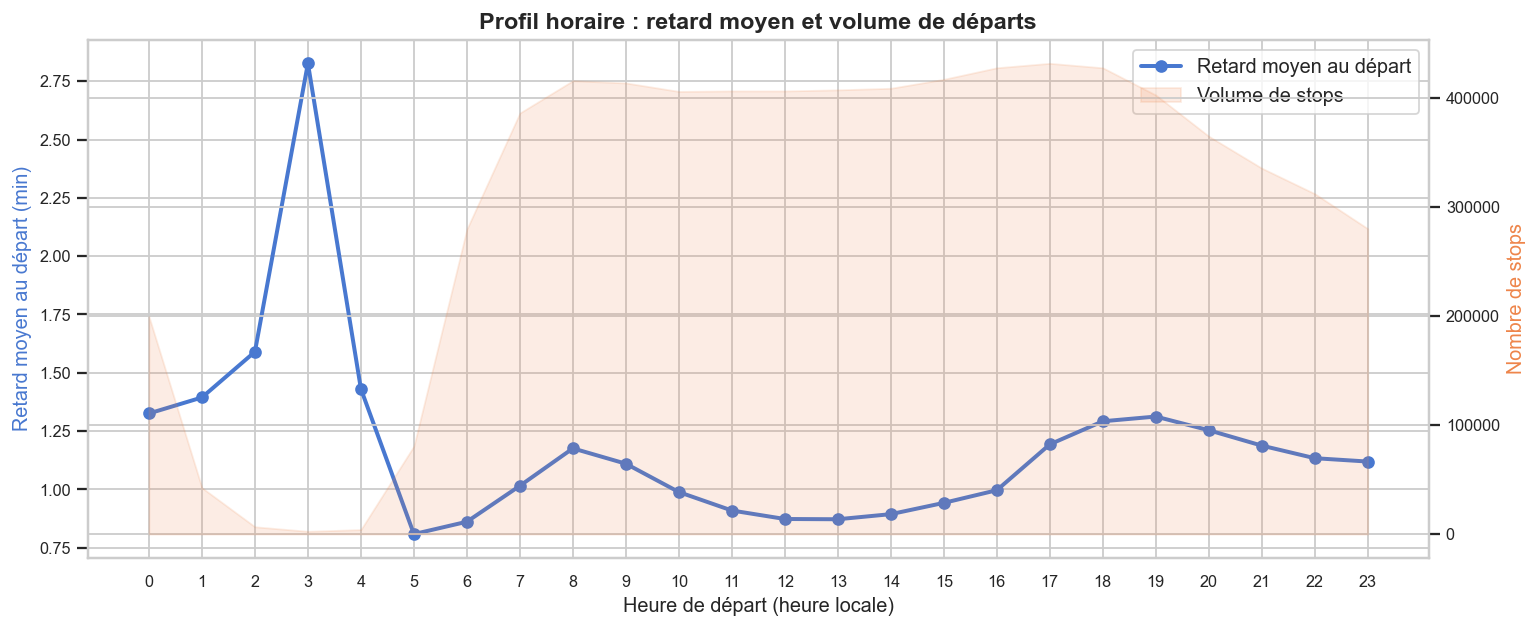

In [52]:
hourly = (
    df_mid
    .dropna(subset=["dep_hour", "Stop:Departure delay"])
    .groupby("dep_hour")
    .agg(
        mean_delay=("Stop:Departure delay", "mean"),
        count=("Stop:Departure delay", "count")
    )
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()

ax2.fill_between(hourly["dep_hour"], hourly["count"], alpha=0.15,
                 color=PALETTE[1], label="Volume de stops")
ax1.plot(hourly["dep_hour"], hourly["mean_delay"], marker="o", linewidth=2.2,
         color=PALETTE[0], markersize=6, label="Retard moyen au départ")

ax1.set_xlabel("Heure de départ (heure locale)")
ax1.set_ylabel("Retard moyen au départ (min)", color=PALETTE[0])
ax2.set_ylabel("Nombre de stops", color=PALETTE[1])
ax1.set_xticks(range(0, 24))
ax1.set_title("Profil horaire : retard moyen et volume de départs", fontweight="bold")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)
plt.tight_layout()
plt.savefig("viz_6_profil_horaire.png", bbox_inches="tight")
plt.show()

This dual-axis chart overlays two signals: the average departure delay (line, left axis) and the number of departures per hour (filled area, right axis). This combination allows us to distinguish whether high-delay hours are caused by congestion or other factors

The night hours (0h–5h) show very low traffic volume; however, the average delay spikes significantly during this period, reaching its highest peak at 3h despite the minimal number of stops. This suggests that late-night delays are likely driven by factors other than traffic volume, such as maintenance or specific nighttime operational constraints. 

Conversely, Delay tends to increase during morning and evening peak hours (roughly 7h–9h and 17h–19h), coinciding with the highest departure volumes. This congestion-delay relationship is an actionable insight: departure hour is a strong candidate feature for the prediction model.

#### Cancellation rates by service type: Total vs Partial

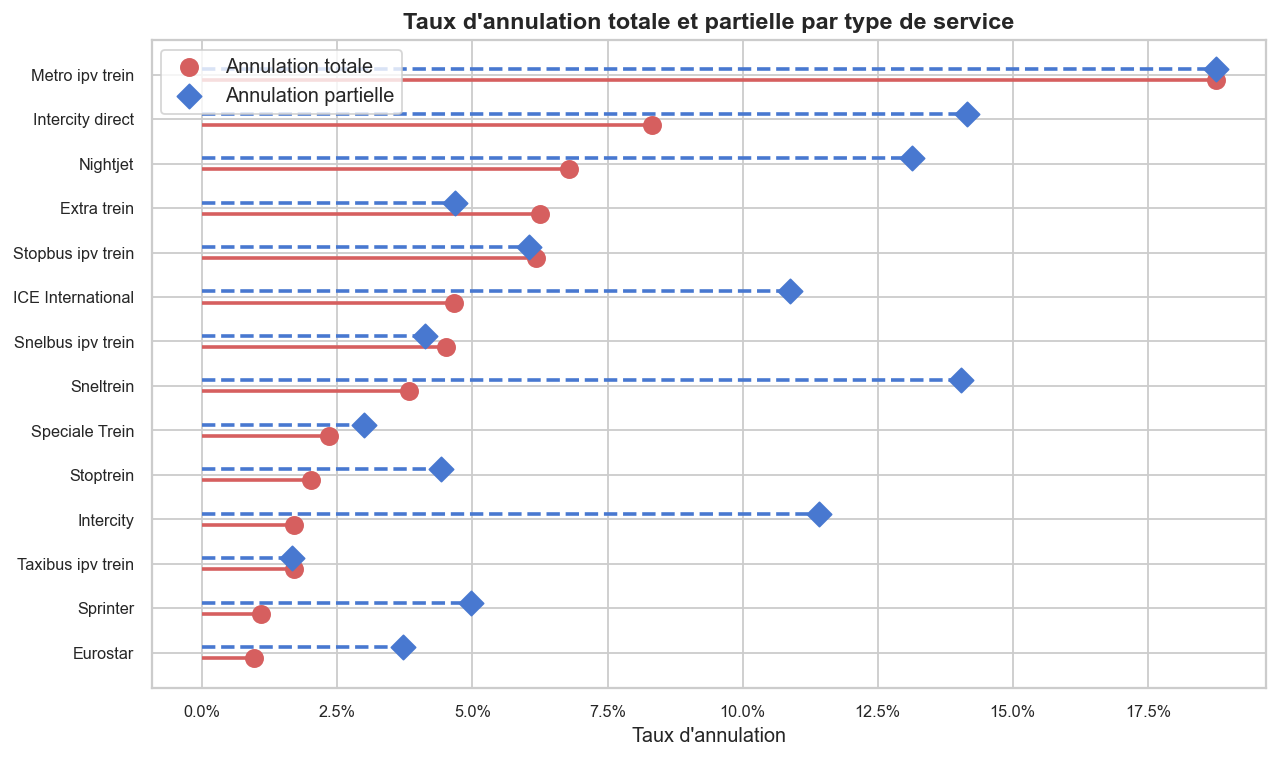

In [56]:
cancel_stats = (
    df_service[df_service["Service:Type"].isin(top_types)]
    .groupby("Service:Type")
    .agg(
        total=("Service:RDT-ID", "count"),
        total_cancel=("Service:Completely cancelled", "sum"),
        partial_cancel=("Service:Partly cancelled", "sum")
    )
    .reset_index()
)
cancel_stats["rate_total"]   = cancel_stats["total_cancel"]   / cancel_stats["total"] * 100
cancel_stats["rate_partial"] = cancel_stats["partial_cancel"] / cancel_stats["total"] * 100
cancel_stats = cancel_stats.sort_values("rate_total", ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(cancel_stats))

# Lollipop : annulation totale
ax.hlines(y_pos, 0, cancel_stats["rate_total"], colors=PALETTE[3], linewidth=2)
ax.scatter(cancel_stats["rate_total"], y_pos, color=PALETTE[3],
           s=90, zorder=5, label="Annulation totale")

# Lollipop : annulation partielle (décalé légèrement)
ax.hlines([y + 0.25 for y in y_pos], 0, cancel_stats["rate_partial"],
          colors=PALETTE[0], linewidth=2, linestyle="--")
ax.scatter(cancel_stats["rate_partial"], [y + 0.25 for y in y_pos],
           color=PALETTE[0], s=90, zorder=5, marker="D", label="Annulation partielle")

ax.set_yticks([y + 0.125 for y in y_pos])
ax.set_yticklabels(cancel_stats["Service:Type"])
ax.xaxis.set_major_formatter(mticker.PercentFormatter())
ax.set_xlabel("Taux d'annulation")
ax.set_title("Taux d'annulation totale et partielle par type de service", fontweight="bold")
ax.legend()
plt.tight_layout()
plt.savefig("viz_7_lollipop_annulations.png", bbox_inches="tight")
plt.show()


This lollipop chart compares the rate of total cancellations (the entire train does not run) versus partial cancellations (one or more stops are skipped) across service types.

Total cancellations are generally rare across all types, but partial cancellations are significantly more frequent, suggesting that operators are more likely to truncate a route than to cancel an entire service. 

Some service types show disproportionately high partial cancellation rates, this may reflect their vulnerability to infrastructure issues or the geographic complexity of their routes.

#### Platform change rate by hour of the day

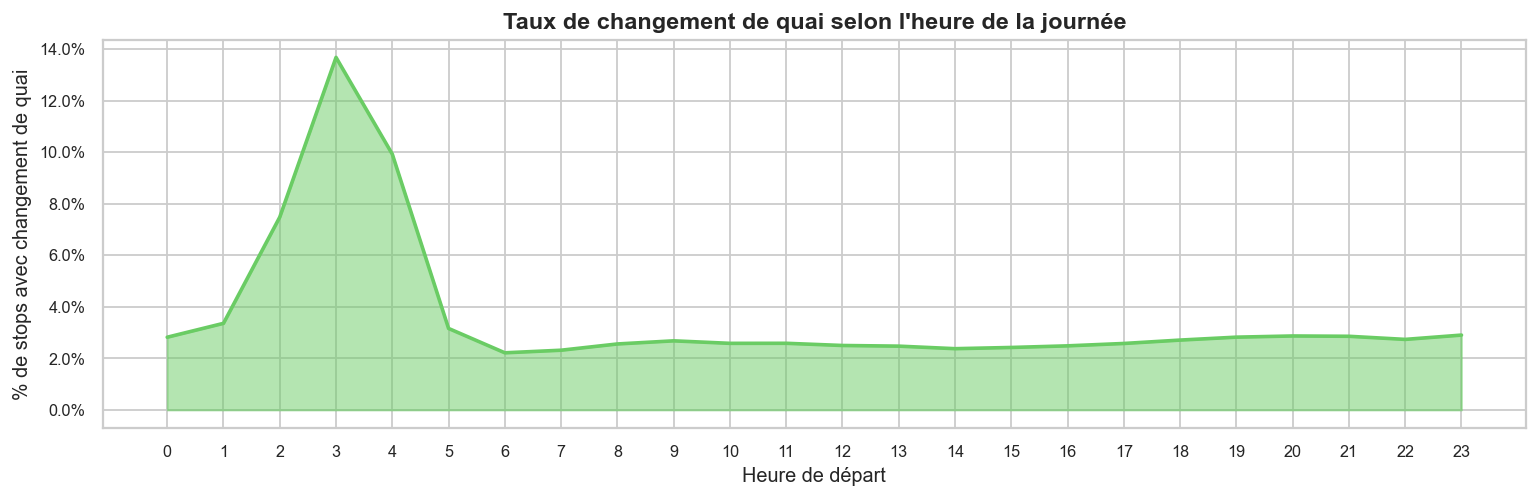

In [58]:
platform_hourly = (
    df_stops
    .dropna(subset=["dep_hour"])
    .groupby("dep_hour")["Stop:Platform change"]
    .agg(["sum", "count"])
    .reset_index()
    .rename(columns={"sum": "changes", "count": "total"})
)
platform_hourly["rate"] = platform_hourly["changes"] / platform_hourly["total"] * 100

fig, ax = plt.subplots(figsize=(12, 4))
ax.fill_between(platform_hourly["dep_hour"], platform_hourly["rate"],
                alpha=0.5, color=PALETTE[2])
ax.plot(platform_hourly["dep_hour"], platform_hourly["rate"],
        color=PALETTE[2], linewidth=2)
ax.set_xticks(range(0, 24))
ax.set_xlabel("Heure de départ")
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.set_ylabel("% de stops avec changement de quai")
ax.set_title("Taux de changement de quai selon l'heure de la journée", fontweight="bold")
plt.tight_layout()
plt.savefig("viz_8_platform_change_heure.png", bbox_inches="tight")
plt.show()

This area chart tracks the proportion of stops where a platform change occurred (the actual platform differed from the scheduled one) across the 24 hours of the day.

Platform changes are not merely an inconvenience for passengers, they are often a sign of operational disruption, rerouting, or congestion at a station. The chart indicates that platform changes occur more frequently in the early morning hours.

#### Maximum delay distribution per operator (capped at 60 min)

C:\Users\bouzi\AppData\Local\Temp\ipykernel_15428\1072291536.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


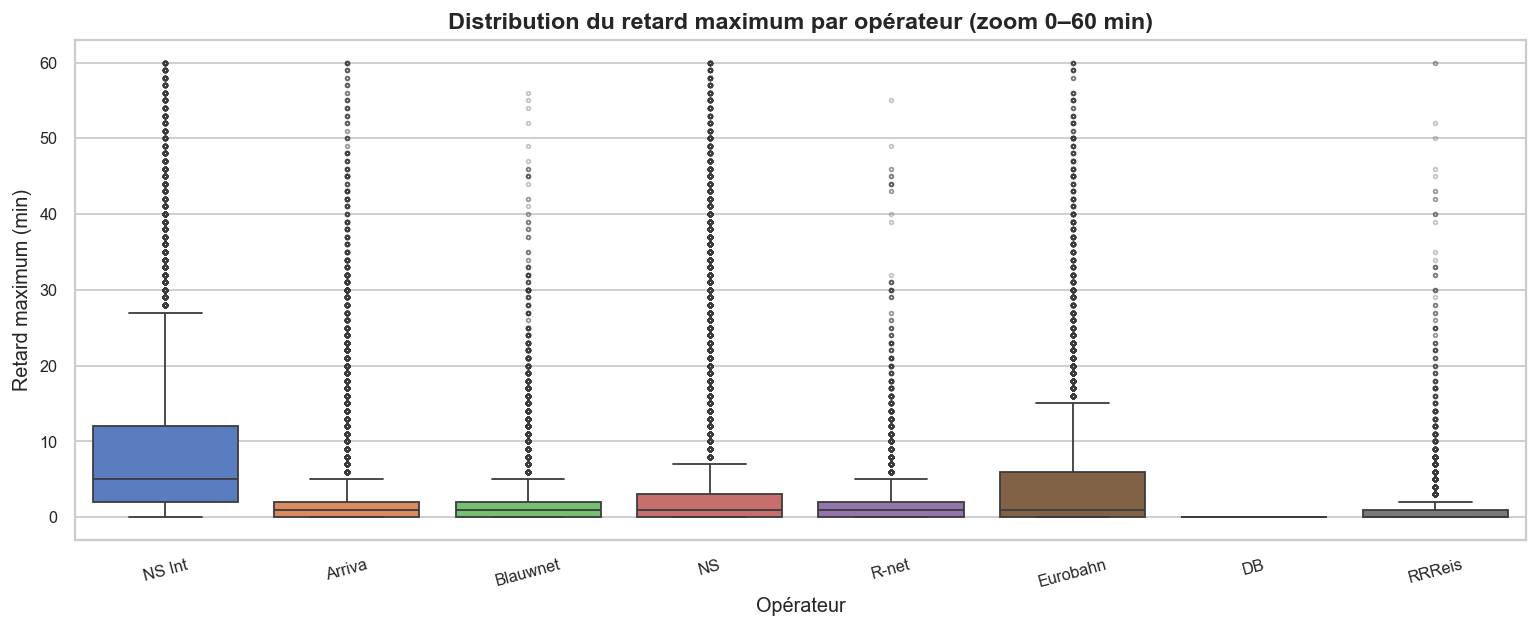

In [59]:
company_order = (
    df_service.groupby("Service:Company")["Service:Maximum delay"]
    .median()
    .sort_values(ascending=False)
    .index
)
top_companies_all = df_service["Service:Company"].value_counts().head(8).index
df_box = df_service[
    df_service["Service:Company"].isin(top_companies_all) &
    df_service["Service:Maximum delay"].between(0, 60)
]

fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(
    data=df_box, x="Service:Company", y="Service:Maximum delay",
    order=[c for c in company_order if c in top_companies_all],
    palette="muted", flierprops={"marker": ".", "alpha": 0.3, "ms": 4},
    ax=ax
)
ax.set_xlabel("Opérateur")
ax.set_ylabel("Retard maximum (min)")
ax.set_title("Distribution du retard maximum par opérateur (zoom 0–60 min)", fontweight="bold")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("viz_9_boxplot_operateur.png", bbox_inches="tight")
plt.show()

The boxplot provides a robust, quartile-based comparison of delay distributions across the main operators. Each box spans the interquartile range (Q1 to Q3), the line inside the box marks the median, and the individual dots represent outlier services.

Operators are ranked by median delay, allowing immediate identification of which companies tend to have more punctual services. The spread of the boxes and the density of outliers vary significantly between operators: some maintain a tight distribution (most services on-time, few extreme delays), while others show wider boxes and more outliers.
This visualization confirms that operator identity is a relevant categorical variable for delay prediction.

#### Annual delay heatmap: average maximum delay by week and day of the week

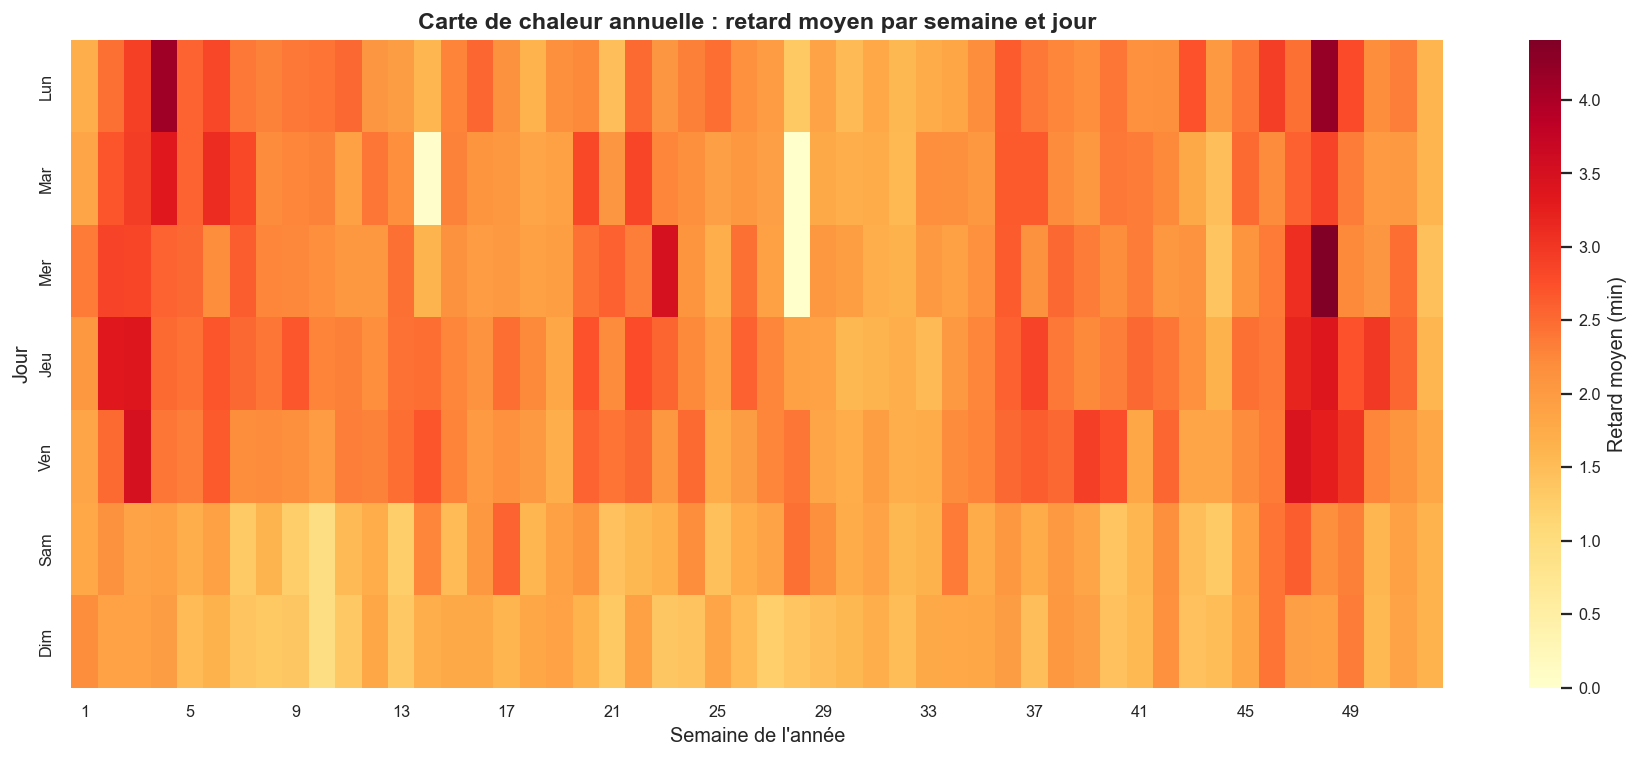

In [60]:
df_service["weekday_num"] = df_service["Service:Date"].dt.weekday  # 0=lun

pivot_wk = (
    df_service
    .groupby(["week", "weekday_num"])["Service:Maximum delay"]
    .mean()
    .unstack("weekday_num")
)
pivot_wk.columns = ["Lun","Mar","Mer","Jeu","Ven","Sam","Dim"]

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(
    pivot_wk.T, cmap="YlOrRd", ax=ax,
    cbar_kws={"label": "Retard moyen (min)"},
    linewidths=0, xticklabels=4
)
ax.set_xlabel("Semaine de l'année")
ax.set_ylabel("Jour")
ax.set_title("Carte de chaleur annuelle : retard moyen par semaine et jour", fontweight="bold")
plt.tight_layout()
plt.savefig("viz_10_heatmap_annuelle.png", bbox_inches="tight")
plt.show()

This annual heatmap provides a global, calendar-level view of delay patterns throughout 2024. Each cell represents the average maximum delay for a specific combination of week number (X-axis) and day of the week (Y-axis). Darker red cells indicate weeks/days with notably higher delays.

This visualization is particularly powerful for identifying anomalous periods at a glance, visible as concentrated red patches. These correspond to specific events such as severe weather episodes, national strikes, or major infrastructure failures. Conversely, extended periods of lighter colors (lower delays) confirm the overall reliability of the Dutch rail network for most of the year.

From a modeling perspective, this heatmap validates the relevance of both the week number and the day of the week as temporal features. The interaction between these two dimensions also suggests that a combined temporal encoding could improve model performance.

Create Time-Based Features

In [5]:
cols= ["Stop:Departure time", "Stop:Arrival time", "Service:Date"]
for c in cols:
    if not pd.api.types.is_datetime64_any_dtype(df_clean[c]):
        df_clean[c] = pd.to_datetime(df_clean[c], errors="coerce")

df_clean["hour_departure"]= df_clean["Stop:Departure time"].dt.hour.astype("Int64")
df_clean["hour_arrival"] = df_clean["Stop:Arrival time"].dt.hour.astype("Int64")
df_clean["day_of_week"] = df_clean["Service:Date"].dt.dayofweek.astype("Int64")
df_clean["month"] = df_clean["Service:Date"].dt.month.astype("Int64")

print("dtypes:")
print(df_clean[cols].dtypes)

df_clean[["hour_departure","hour_arrival","day_of_week","month"]].head()

dtypes:
Stop:Departure time    datetime64[ns, UTC+01:00]
Stop:Arrival time      datetime64[ns, UTC+01:00]
Service:Date                      datetime64[ns]
dtype: object


,hour_departure,hour_arrival,day_of_week,month
0,2,<NA>,0,1
1,2,2,0,1
2,2,2,0,1
3,2,2,0,1
4,3,3,0,1


#### Monthly Average Delay

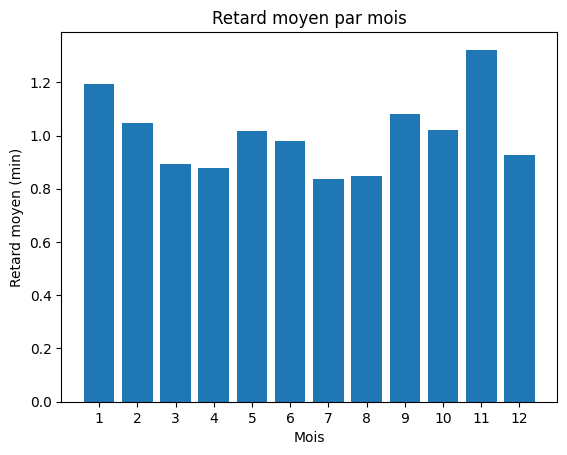

In [8]:
grp = df_clean.groupby("month")["Stop:Arrival delay"].mean()

plt.figure()
plt.bar(grp.index.astype(str), grp.values)
plt.title("Retard moyen par mois")
plt.xlabel("Mois")
plt.ylabel("Retard moyen (min)")
plt.show()


Delays appear to be:
1. Higher at the beginning of the year (January)
2. Increasing again toward the end of the year (especially November)
3. Lower during mid-year months (around July and August)

This pattern may indicate mild seasonality, potentially linked to weather conditions, traffic demand, or operational factors. However, the variations remain relatively small, meaning the seasonality effect is present but not strongly pronounced

#### Departure/Arrival Relationship

We visualize the relationship between Stop:Departure delay and Stop:Arrival delay (on a sample) to avoid an overly heavy plot.

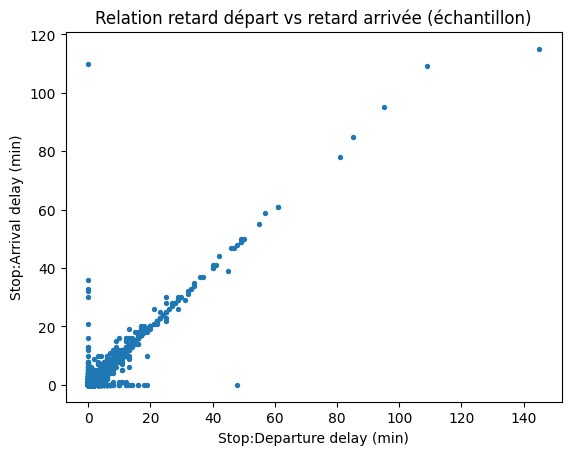

In [9]:
tmp = df_clean[df_clean["Stop:Departure delay"].notna()].copy()

# Scatter sur un échantillon pour éviter un plot trop lourd
sample = tmp.sample(n=min(20000, len(tmp)), random_state=42)

plt.figure()
plt.scatter(sample["Stop:Departure delay"], sample["Stop:Arrival delay"], s=8)
plt.title("Relation retard départ vs retard arrivée (échantillon)")
plt.xlabel("Stop:Departure delay (min)")
plt.ylabel("Stop:Arrival delay (min)")
plt.show()


#### Average Delay per Station

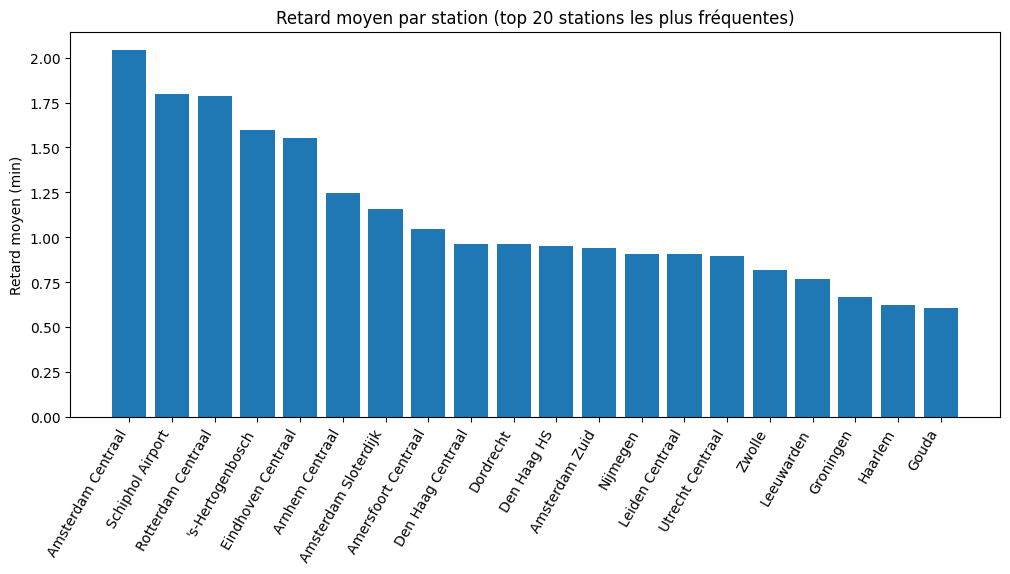

In [11]:
col = "Stop:Station name"
top_stations = df_clean[col].value_counts().head(20).index
tmp = df_clean[df_clean[col].isin(top_stations)]

grp = tmp.groupby(col)["Stop:Arrival delay"].mean().sort_values(ascending=False)

plt.figure(figsize=(12,5))
plt.bar(grp.index.astype(str), grp.values)
plt.title("Retard moyen par station (top 20 stations les plus fréquentes)")
plt.xticks(rotation=60, ha="right")
plt.ylabel("Retard moyen (min)")
plt.show()
